In [15]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
import warnings
import math
from typing import Callable, Optional
from typings import ObjectiveOracle, GradientOracle, ProximalOracle, InputData, Axis
from typings import FactorMatrix, Direction, ProjectionOracle, Momentum, StepSize, Diagnostics
from generate_data import generate_Ls, generate_sylvester_data
from proximal_gradient_descent import project_to_lower_with_positive_diag

In [16]:
def _gradient(Mss, X, chosen_axis, chosen_group):
    """
    Pick an axis f
    sum_g1 sum_g2 tr[
        L_{f_∈g1}^T mat_f[[X;{L_{f'∈g_1}}_{f'!=f}]]
        mat_f[[X;{L_{f'∈g_1}}_{f'!=f}]]^T L_{f_∈g2}
    ]

    TODO: DIFFERENTIATE
    """
    result = 0
    for g1, group1 in enumerate(Mss):
        for g2, group2 in enumerate(Mss):
            if g1 != chosen_group and g2 != chosen_group:
                continue
            left = X
            right = X

            for axis, (factor1, factor2) in enumerate(zip(group1, group2)):
                if axis == chosen_axis:
                    continue
                left = left.swapaxes(-1, axis).dot(factor1).swapaxes(-1, axis)
                right = right.swapaxes(-1, axis).dot(factor2).swapaxes(-1, axis)
            
            factor1 = group1[chosen_axis]
            factor2 = group2[chosen_axis]
            left = left.swapaxes(chosen_axis, 0).reshape(factor1.shape[0], -1)
            right = right.swapaxes(chosen_axis, 0).reshape(factor2.shape[0], -1)

            if g1 == chosen_group and g2 == chosen_group:
                right = factor2.T @ right
                result += 2 * left @ right.T
            elif g2 == chosen_group:
                left = factor1.T @ left
                result += (left @ right.T).T
            elif g1 == chosen_group:
                right = factor1.T @ right
                result += left @ right.T
            else:
                raise Exception("How?")
    return np.tril(result)

In [17]:
def get_optimizer_oracles_generalized(
    X: InputData,
    frobreg: float = None,
    glassoregs: Optional[tuple[float, ...] | float] = None,
    sample_axes: set[Axis] = set({}),
    num_groups: int = 1
) -> tuple[ObjectiveOracle, GradientOracle, ProximalOracle]:
    """
    Creates oracles from our input data

    Sample-axes are treated as known-to-be-independent, and are not updated;
        they will stay at whatever they are initialized to be (typically the identity matrix)
    """
    if frobreg is None:
        frobreg = 1/np.prod(X.shape)**(1/len(X.shape))
    if glassoregs is None:
        glassoregs = [0 for _ in range(X.ndims)]
    if isinstance(glassoregs, float | int):
        glassoregs = [glassoregs for _ in range(X.ndim)]

    ndims = X.ndim

    objective: ObjectiveOracle
    def objective(Lss: list[list[FactorMatrix]], decomp=False) -> float:
        # trace_term = 0
        # for g1 in range(num_groups):
        #     Ls = Lss[g1]
        #     vec_1 = X
        #     for factor in range(ndims):
        #         #vec_1 = np.tensordot(vec_1, Ls[factor], [factor, 1])
        #         vec_1 = vec_1.swapaxes(-1, factor).dot(Ls[factor]).swapaxes(-1, factor)
        #     vec_1 = vec_1.reshape(-1)
        #     for g2 in range(num_groups):
        #         Ls = Lss[g2]
        #         vec_2 = X
        #         for factor in range(ndims):
        #             vec_2 = vec_2.swapaxes(-1, factor).dot(Ls[factor]).swapaxes(-1, factor)
        #         vec_2 = vec_2.reshape(-1)
        #         trace_term += vec_1 @ vec_2
        full_dot = 0
        for group1 in Lss:
            for group2 in Lss:
                left = X
                right = X

                for axis, (factor1, factor2) in enumerate(zip(group1, group2)):
                    left = left.swapaxes(-1, axis).dot(factor1).swapaxes(-1, axis)
                    right = right.swapaxes(-1, axis).dot(factor2).swapaxes(-1, axis)

                full_dot += (left * right).sum()
        trace_term = full_dot

        log_term = 0
        for g1 in range(num_groups):
            Ls = Lss[g1]
            cur_log_term = np.diag(Ls[0])
            for L in Ls[1:]:
                cur_log_term = np.add.outer(cur_log_term, np.diag(L))
            log_term += cur_log_term
        log_term = -2 * np.log(log_term).sum()

        frob_term = 0
        for Ls in Lss:
            for L in Ls:
                frob_term += (L**2).sum()
        frob_term *= frobreg
        
        differentiable_term = trace_term + log_term + frob_term

        if (np.isnan(differentiable_term)):
            raise ValueError("NaN in differentiable term")
        

        nondifferentiable_term = sum(
            sum([
                glassoregs[i] * np.abs(np.tril(L)).sum()
                for i, L in enumerate(Ls)
            ])
            for Ls in Lss
        )
        if decomp:
            return differentiable_term, nondifferentiable_term

        return differentiable_term + nondifferentiable_term
    
    gradient: GradientOracle
    def gradient(Lss: list[list[FactorMatrix]]) -> Direction:        
        grads = [[None] * len(Lss[0])] * len(Lss)

        full_log_term = 0
        for Ls in Lss:
            cur_log_term = np.diag(Ls[0])
            for L in Ls[1:]:
                cur_log_term = np.add.outer(cur_log_term, np.diag(L))
            full_log_term += cur_log_term
        full_log_term = (-2 / full_log_term)

        for group, Ls in enumerate(Lss):
            for factor, L in enumerate(Ls):
                if factor in sample_axes:
                    grads[group][factor] = np.zeros_like(L)
                    continue

                # L_sum = sum([_Ls[factor] for _Ls in Lss])
                # X_mat = X
                # for other_factor, other_L in enumerate(Ls):
                #     if other_factor == factor:
                #         continue
                #     #X_mat = np.tensordot(X_mat, other_L, [other_factor, 1])
                #     X_mat = X_mat.swapaxes(-1, other_factor).dot(other_L).swapaxes(-1, other_factor)
                # X_mat = X_mat.swapaxes(0, factor).reshape(L.shape[0], -1)
                # S = X_mat @ X_mat.T
                # trace_term = S @ L_sum

                # trace_term = np.tril(2 * trace_term)
                trace_term = _gradient(Lss, X, factor, group)

                log_term = np.diag(full_log_term.swapaxes(factor, 0).reshape(L.shape[0], -1).sum(axis=1))
                frob_term = 2*frobreg*L

                grads[group][factor] = trace_term + log_term + frob_term

        return grads
    
    proximal: ProximalOracle
    def proximal(Lss: list[list[FactorMatrix]]) -> list[list[FactorMatrix]]:
        """
        Soft thresholding on each of the Ls, not affecting their diagonals
        """
        new_Lss = []
        for group, Ls in enumerate(Lss):
            new_Ls = []
            for i, L in enumerate(Ls):
                if i in sample_axes:
                    new_Ls.append(L)
                    continue
                L_diag = np.diag(L)
                new_L = np.sign(L) * np.maximum(np.abs(L) - glassoregs[i], 0)
                np.fill_diagonal(new_L, L_diag)
                new_Ls.append(new_L)
            new_Lss.append(new_Ls)
        return new_Lss
    
    return objective, gradient, proximal

project_to_lower_with_positive_diag: ProjectionOracle
def project_to_lower_with_positive_diag(Ms: list[FactorMatrix], tol=1e-6) -> list[FactorMatrix]:
    """
    Project M to strictly lower-triangular + positive diagonal
    """

    Ls = []
    for M in Ms:
        L = np.tril(M)
        np.fill_diagonal(L, np.maximum(np.diag(L), tol))  # Ensure positive diag
        Ls.append(L)
    return Ls

In [18]:
def proximal_accelerated_gradient(
    f: ObjectiveOracle,
    del_f: GradientOracle,
    prox: ProximalOracle,
    P: ProjectionOracle,
    Lss: list[list[FactorMatrix]],
    mu: Momentum,
    init_alpha: StepSize,
    tau: float,
    beta: float,
    max_iter: int = 1000,
    tol: float = 1e-5,
    verbose: bool = False
) -> tuple[list[FactorMatrix], Diagnostics]:
    """
    Gradient descent algorithm
    """

    cur_f = f(Lss)

    objs = []
    eps = []
    grads = []
    nonzeros = [[[] for _ in Ls] for Ls in Lss]
    
    for i in range(max_iter):
        grad = del_f(Lss)
        if i > 0 and mu > 0:
            accelerated_Lss = [
                P([L + mu * (L - old_L) for L, old_L in zip(Ls, oldest_Ls)])
                for oldest_Ls in oldest_Lss
            ]
        else:
            accelerated_Lss = Lss
        oldest_Lss = Lss
        

        Lss = proximal_backtracking_line_search(f, prox, P, grad, accelerated_Lss, init_alpha, tau, beta)

        new_f = f(Lss)
        delta = new_f - cur_f
        objs.append(new_f)
        eps.append(delta)
        grads.append(sum([sum([np.linalg.norm(_g) for _g in g]) for g in grad]))

        if verbose:
            print(f"Iteration {i}: {delta=:.2e}")

        for group, Ls in enumerate(Lss):
            for factor, L in enumerate(Ls):
                nonzeros[group][factor].append(np.count_nonzero(L))
        
        if np.abs(delta) < tol:
            break
        cur_f = new_f

    return Ls, (objs, eps, grads, nonzeros)

def proximal_backtracking_line_search(
    f: ObjectiveOracle,
    prox: ProximalOracle,
    P: ProjectionOracle,
    del_f: Direction,
    Lss: list[list[FactorMatrix]],
    init_alpha: StepSize,
    tau: float,
    beta: float
) -> list[FactorMatrix]:
    """
    Backtracking line search
    """
    alpha = init_alpha
    
    cur_f = f(Lss)
    while True:
        new_Lss = prox([P([L - alpha * d for L, d in zip(Ls, df)]) for Ls, df in zip(Lss, del_f)])

        new_f = f(new_Lss)
        prox_direc = [[(L - Lnew) for L, Lnew in zip(Ls, Lsnew)] for Ls, Lsnew in zip(Lss, new_Lss)]
        grad_norm = sum(sum([np.linalg.norm(d)**2 for d in ds]) for ds in prox_direc)
        if new_f <= cur_f - beta * grad_norm / alpha:
            break
        alpha *= tau
        if alpha < 1e-30:
            warnings.warn("Alpha too small, stopping line search")
            return Lss

    return new_Lss

In [19]:
np.random.seed(0)
dims = (20, 21)
num_groups = 1
sparsity = 0.1
Ls, L_patterns = generate_Ls(dims, sparsity=sparsity)
X = generate_sylvester_data(Ls, normalize=True, source_distribution=np.random.normal)

L_init = [[np.eye(d) for d in dims] for _ in range(num_groups)]

frobreg = 1/np.prod(dims)**(1/len(dims))
glassoreg = 0.5e-6
objective, gradient, proximal = get_optimizer_oracles_generalized(X, frobreg=frobreg, glassoregs=glassoreg, num_groups=num_groups)

Ls, (_, eps, _, _) = proximal_accelerated_gradient(
    f=objective,
    del_f=gradient,
    prox=proximal,
    P=project_to_lower_with_positive_diag,
    Lss=L_init,
    mu=0,#0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=1000,
    tol=1e-20,
    verbose=True
)

Iteration 0: delta=-1.01e+02
Iteration 1: delta=-7.84e+02
Iteration 2: delta=-7.69e+01
Iteration 3: delta=-6.69e+01
Iteration 4: delta=-4.31e+00
Iteration 5: delta=-1.06e+01
Iteration 6: delta=-1.02e+01
Iteration 7: delta=-1.25e+01
Iteration 8: delta=-4.82e+00
Iteration 9: delta=-1.17e+01
Iteration 10: delta=-2.39e+00
Iteration 11: delta=-1.30e+01
Iteration 12: delta=-2.09e+01
Iteration 13: delta=-1.08e+01
Iteration 14: delta=-1.51e+00
Iteration 15: delta=-3.25e+01
Iteration 16: delta=-1.49e+00
Iteration 17: delta=-3.61e+01
Iteration 18: delta=-2.19e+01
Iteration 19: delta=-1.11e+01
Iteration 20: delta=-1.30e+01
Iteration 21: delta=-3.51e+00
Iteration 22: delta=-2.58e+01
Iteration 23: delta=-8.95e+00
Iteration 24: delta=-9.54e+00
Iteration 25: delta=-8.60e+00
Iteration 26: delta=-8.29e+00
Iteration 27: delta=-4.57e+00
Iteration 28: delta=-9.07e+00
Iteration 29: delta=-7.08e+00
Iteration 30: delta=-6.15e+00
Iteration 31: delta=-5.62e+00
Iteration 32: delta=-1.17e+00
Iteration 33: delta=

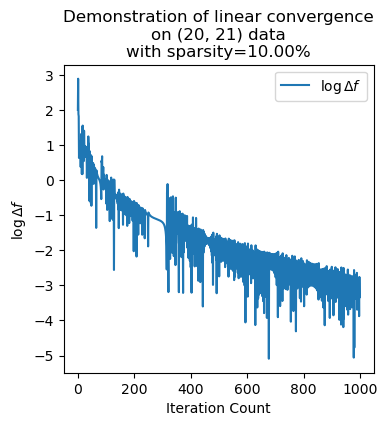

In [20]:
del_f = -np.array(eps)
iterations = np.arange(len(eps))
#iterations = iterations[del_f > 0]
del_f = np.log10(del_f)#[del_f > 0])

#linear_data = iterations > 100
#slope, intercept = np.polyfit(iterations[linear_data], del_f[linear_data], deg=1)

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(iterations, del_f, label=r"$\log\Delta f$")
ax.set_title(f"Demonstration of linear convergence\non {dims} data\nwith {sparsity=:.2%}")
ax.set_xlabel("Iteration Count")
ax.set_ylabel(rf"$\log\Delta f$")
#ax.axline(xy1=(0, intercept), slope=slope, linestyle='--', color='orange', label=f'Linear Rate ({slope=:.2f})')
ax.legend()
pass